In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

station = pd.read_csv("./094/station.csv", sep='\t')
patient = pd.read_csv("./094/patient.csv", sep='\t')
observation = pd.read_csv("./094/observation.csv", sep='\t')

### 1.1 Základný opis dát spolu s ich charakteristikami_porno_

In [43]:
# (A-1b)

# Смотрим первые строки
print("Station cintorin slavicie:")
print(station.head())

# Размер таблицы (строки, столбцы)
print("Station size: ", station.shape)

# Информация о типах данных и пропусках
station.info()

# Основные статистики  
station.describe()

Station cintorin slavicie:
   longitude              revision        station         QoS  latitude  \
0  123.33471  12/25/2024, 00:00:00        Dipolog  acceptable   8.56697   
1  -74.38987            2019-12-13  Scotch Plains        good  40.65538   
2  -79.62098            2024-04-09       Chilibre        good   9.15093   
3  101.02083           06 Nov 2020    Teluk Intan   excellent   4.02219   
4  -13.68778  06/04/2016, 00:00:00      Camayenne        good   9.53500   

            location  
0        Asia/Manila  
1   America/New_York  
2     America/Panama  
3  Asia/Kuala_Lumpur  
4     Africa/Conakry  
Station size:  (798, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  798 non-null    float64
 1   revision   798 non-null    object 
 2   station    798 non-null    object 
 3   QoS        798 non-null    object 
 4   latitude   

,longitude,latitude
count,798.000000,798.000000
mean,7.533613,30.049260
std,74.086131,22.707970
min,-156.474320,-54.800000
25%,-71.089770,17.649250
50%,8.872390,36.634030
75%,68.949943,46.670465
max,178.004170,68.798330


In [42]:
rev = station["revision"]
skin_temp = observation["Skin Temperature"]
spo = observation["SpO₂"]
print("REV \n", rev.describe(include="all"))
print("SPO \n", spo.describe(include="all"))
# skin_temp.value_counts().plot(kind="bar")


# skin_temp.plot()
#dups2 = patient.duplicated()


# report if there are any duplicates
# print(dups.any())
#print(dups2.any())


# list all duplicate rows
# print(station[dups])
#print(patient[dups2])

REV 
 count             798
unique            775
top       30 Nov 2017
freq                3
Name: revision, dtype: object
SPO 
 count    12081.000000
mean        97.543356
std          0.604163
min         95.000000
25%         97.143688
50%         97.548163
75%         97.952928
max        100.000000
Name: SpO₂, dtype: float64


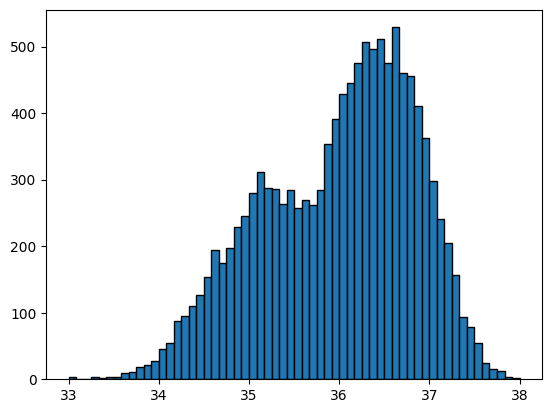

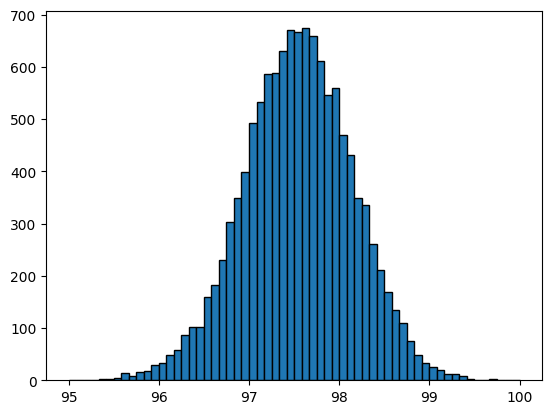

In [33]:
plt.hist(skin_temp, bins=60, edgecolor="black")
plt.show()
plt.hist(spo, bins=60, edgecolor="black")
plt.show()